Columns in DataFrame: Index(['Rainfall - (MM)', 'Year', 'Month'], dtype='object')
Epoch 1/200
28/28 [==============================] - 7s 59ms/step - loss: 0.0247 - val_loss: 0.0269
Epoch 2/200
28/28 [==============================] - 1s 33ms/step - loss: 0.0215 - val_loss: 0.0253
Epoch 3/200
28/28 [==============================] - 1s 31ms/step - loss: 0.0216 - val_loss: 0.0249
Epoch 4/200
28/28 [==============================] - 1s 30ms/step - loss: 0.0210 - val_loss: 0.0242
Epoch 5/200
28/28 [==============================] - 1s 30ms/step - loss: 0.0210 - val_loss: 0.0246
Epoch 6/200
28/28 [==============================] - 1s 30ms/step - loss: 0.0205 - val_loss: 0.0250
Epoch 7/200
28/28 [==============================] - 1s 30ms/step - loss: 0.0204 - val_loss: 0.0232
Epoch 8/200
28/28 [==============================] - 1s 29ms/step - loss: 0.0200 - val_loss: 0.0216
Epoch 9/200
28/28 [==============================] - 1s 31ms/step - loss: 0.0203 - val_loss: 0.0213
Epoch 10/200
28/28

c:\Users\Abdul Basit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


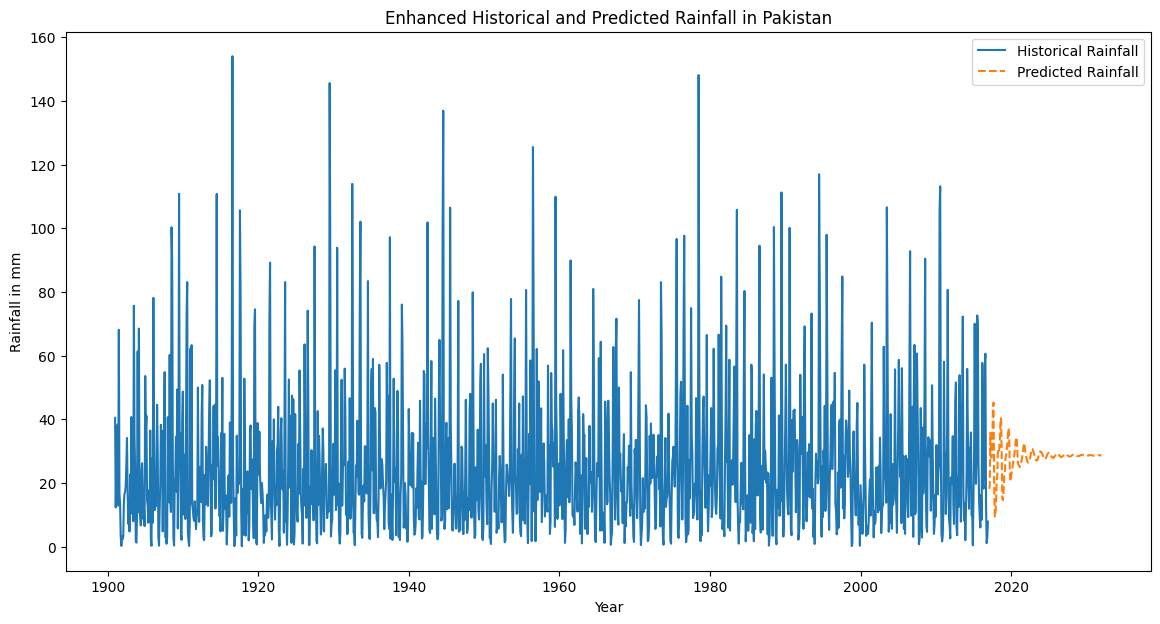

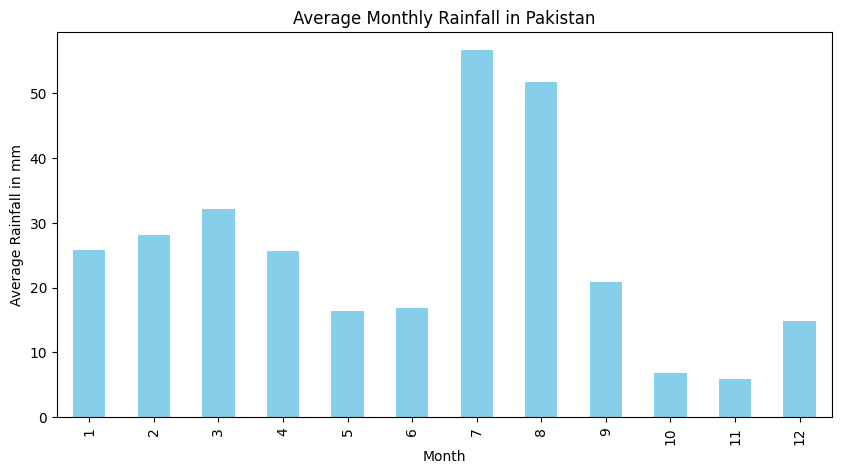

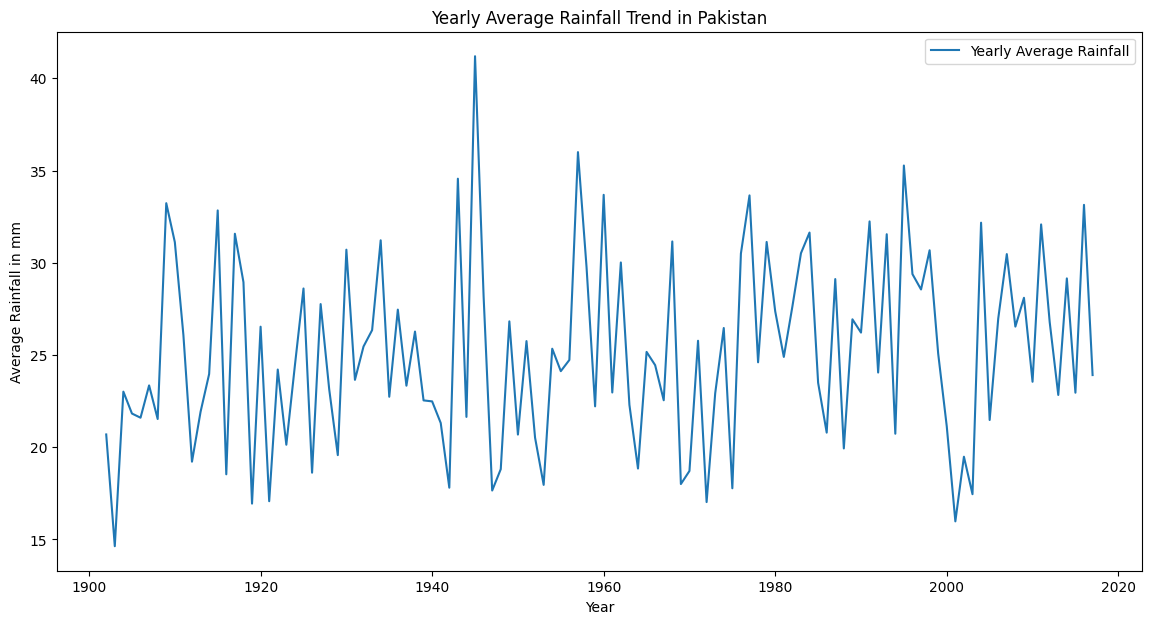

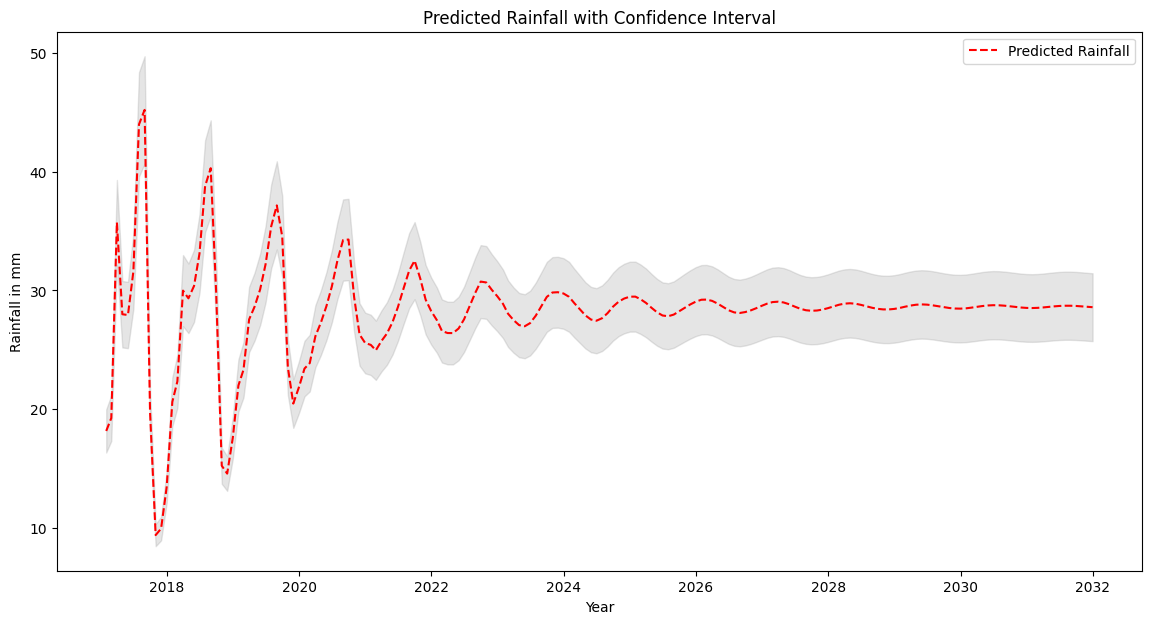

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv('Rainfall_1901_2016_PAK.csv')

data.columns = data.columns.str.strip()  

print("Columns in DataFrame:", data.columns)

data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str) + '-01')
data.set_index('Date', inplace=True)
data = data[['Rainfall - (MM)']] 

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, time_steps=12):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 12 
X, y = create_sequences(data_scaled, time_steps)

X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[early_stopping]
)

y_pred = model.predict(X_test)
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

def predict_future(model, data, steps, scaler):
    predictions = []
    current_input = data[-time_steps:] 

    for _ in range(steps):
        prediction = model.predict(current_input.reshape((1, time_steps, 1)))
        predictions.append(prediction[0, 0])
        current_input = np.append(current_input[1:], prediction)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

future_years = 2030 - data.index[-1].year + 1
future_predictions = predict_future(model, data_scaled, future_years * 12, scaler)

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Rainfall - (MM)'], label='Historical Rainfall')
future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=future_years * 12, freq='M')
plt.plot(future_dates, future_predictions, label='Predicted Rainfall', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Rainfall in mm')
plt.title('Enhanced Historical and Predicted Rainfall in Pakistan')
plt.legend()
plt.show()

monthly_avg = data.groupby(data.index.month)['Rainfall - (MM)'].mean()
plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Rainfall in mm')
plt.title('Average Monthly Rainfall in Pakistan')
plt.show()

# Visualization: Rainfall Trend over the Years
yearly_avg = data.resample('Y').mean()
plt.figure(figsize=(14, 7))
plt.plot(yearly_avg.index, yearly_avg['Rainfall - (MM)'], label='Yearly Average Rainfall')
plt.xlabel('Year')
plt.ylabel('Average Rainfall in mm')
plt.title('Yearly Average Rainfall Trend in Pakistan')
plt.legend()
plt.show()

# Visualization: Error Analysis
plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_predictions, label='Predicted Rainfall', linestyle='--', color='red')
plt.fill_between(future_dates, future_predictions.flatten() - 0.1 * future_predictions.flatten(), 
                 future_predictions.flatten() + 0.1 * future_predictions.flatten(), color='gray', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Rainfall in mm')
plt.title('Predicted Rainfall with Confidence Interval')
plt.legend()
plt.show()
